In [1]:
from pathlib import Path
import json

from matplotlib import pyplot as plt
import pandas as pd

In [2]:
text = Path("../Report/images/tensorboard.har").read_text()
har = json.loads(text)

text_set = set(
    entry["response"]["content"]["text"]
    for entry in filter(
        lambda entry: entry["request"]["url"].endswith("timeSeries"),
        har["log"]["entries"],
    )
)

data = [json.loads(text)[0] for text in text_set]


In [3]:
dump = {}

for obj in data:
    if obj["tag"] == "Loss/test":
        continue

    tag = obj["tag"].split("/")[0]
    for key, val in obj["runToSeries"].items():
        opt = key.split("-")[-1]

        step = [item["step"] for item in val]
        value = [item["value"] for item in val]
        dump[f"{opt}/{tag}"] = pd.Series(data=value, index=step)

df = pd.DataFrame(dump)
df.head()


,SGD/Loss,AdamW/Loss,RAdam/Loss,Adam/Loss,SGD/LR,AdamW/LR,RAdam/LR,Adam/LR
3,2.302278,2.302273,2.302278,2.302273,0.000102,0.000001,0.000001,0.000001
4,2.303956,2.303950,2.303956,2.303950,0.000102,0.000001,0.000001,0.000001
10,2.303935,2.303920,2.303936,2.303920,0.000106,0.000001,0.000001,0.000001
14,2.302965,2.302943,2.302965,2.302943,0.000108,0.000001,0.000001,0.000001
15,2.303123,2.303099,2.303124,2.303099,0.000108,0.000001,0.000001,0.000001


In [4]:
def locate_lr_range(opt):
    diff = df[f"{opt}/Loss"].rolling(128, center=True).mean().diff(-1).rolling(8, center=True).mean()
    diff = diff * (diff > 0)
    return df[f"{opt}/LR"][diff > diff.mean()]


def plot(ax1, opt, ymax):
    # ax1.set_title(opt)
    ax2 = ax1.twinx()

    yLoss = df[f"{opt}/Loss"]
    ax1.set_ylabel("Loss")

    yLR = df[f"{opt}/LR"].copy()
    ax2.set_ylabel("Learning Rate")

    if ymax <= 0.01:
        ymax *= 1000
        yLR *= 1000
        ax2.set_ylabel("Learning Rate (x1000)")

    lr_range = locate_lr_range(opt)
    ax1.fill_between(lr_range.index, 1.4, 2.4, alpha=0.36)

    ax1.scatter(df.index, yLoss, s=1, label="Loss")
    ax2.plot(yLR, label="Learning Rate")
    # ax2.plot(df[f"{opt}/Loss"].rolling(200, center=True).mean().diff(-1).rolling(16, center=True).mean(), label='diff loss')

    ax1.set_xlim(0, 2400)
    ax1.set_ylim(1.4, 2.4)
    ax2.set_ylim(0, ymax)
    # ax2.set_ylim(-0.005, 0.005)

    ax1.grid(axis="x")
    ax2.grid()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")


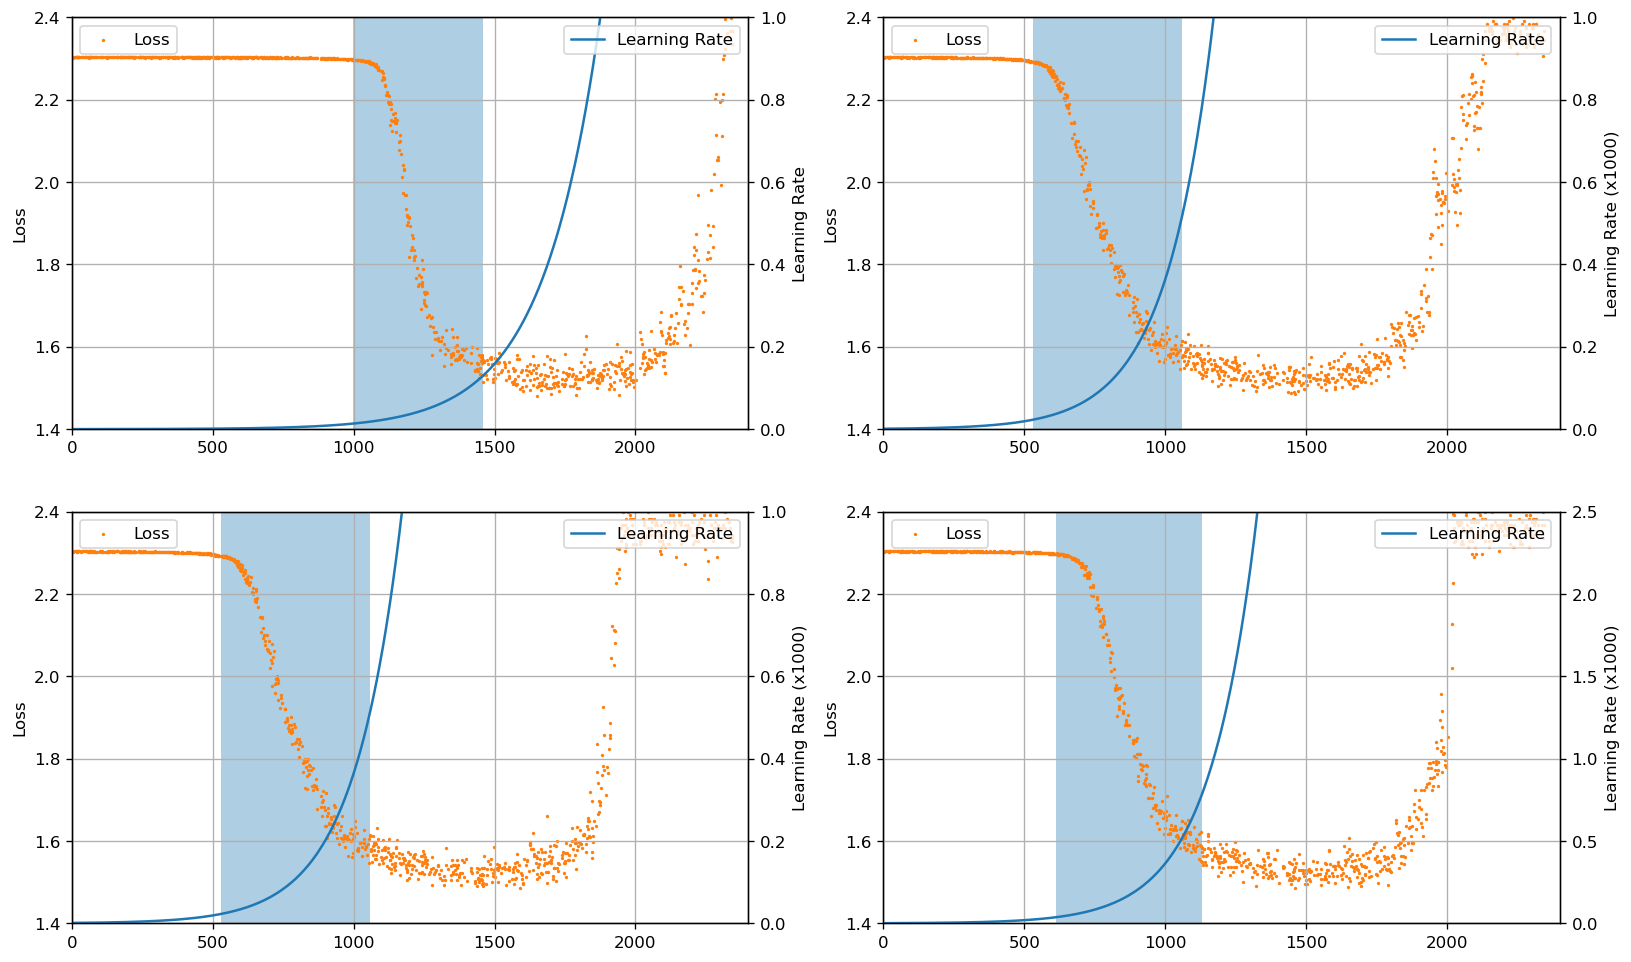

In [5]:
fix, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=120)

plot(axes[0][0], "SGD", 1)
plot(axes[0][1], "Adam", 0.0010)
plot(axes[1][0], "AdamW", 0.0010)
plot(axes[1][1], "RAdam", 0.0025)

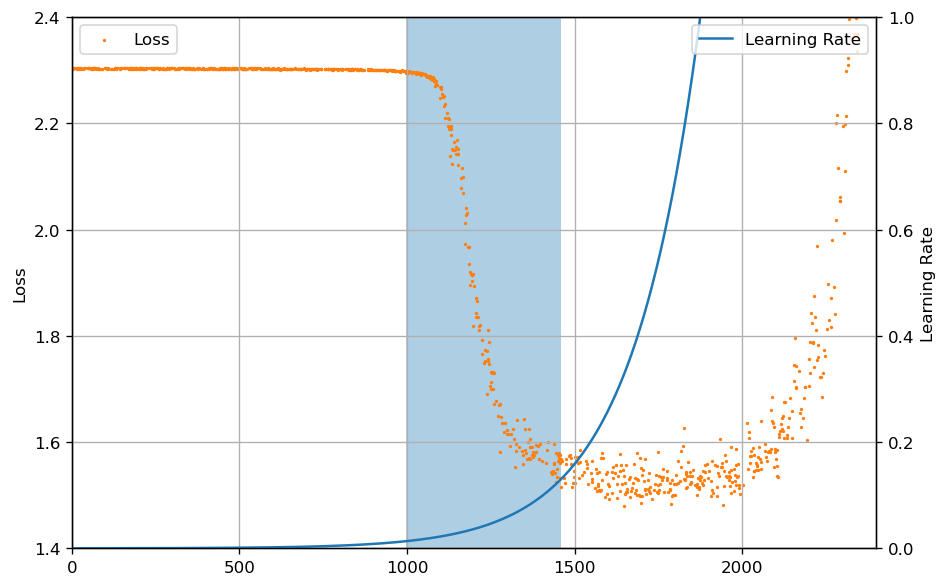

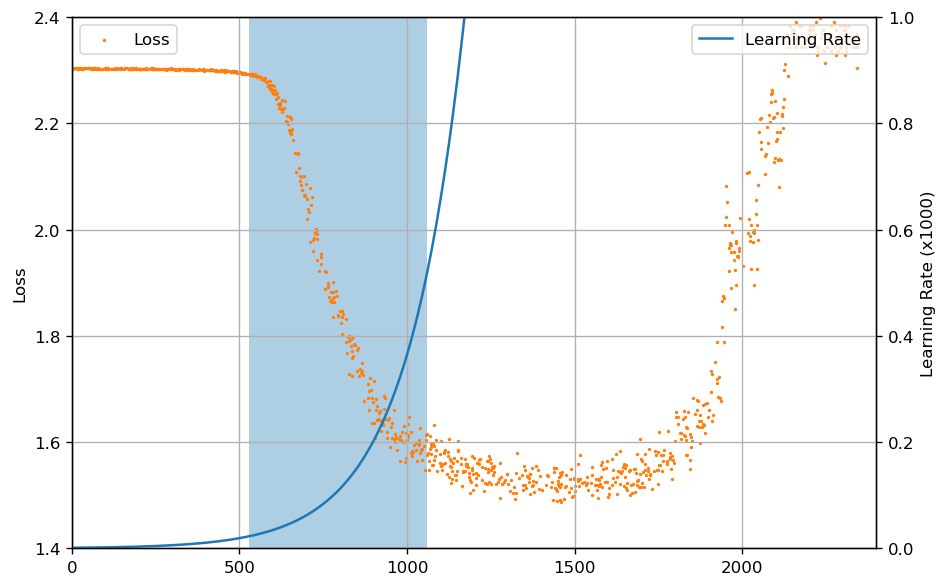

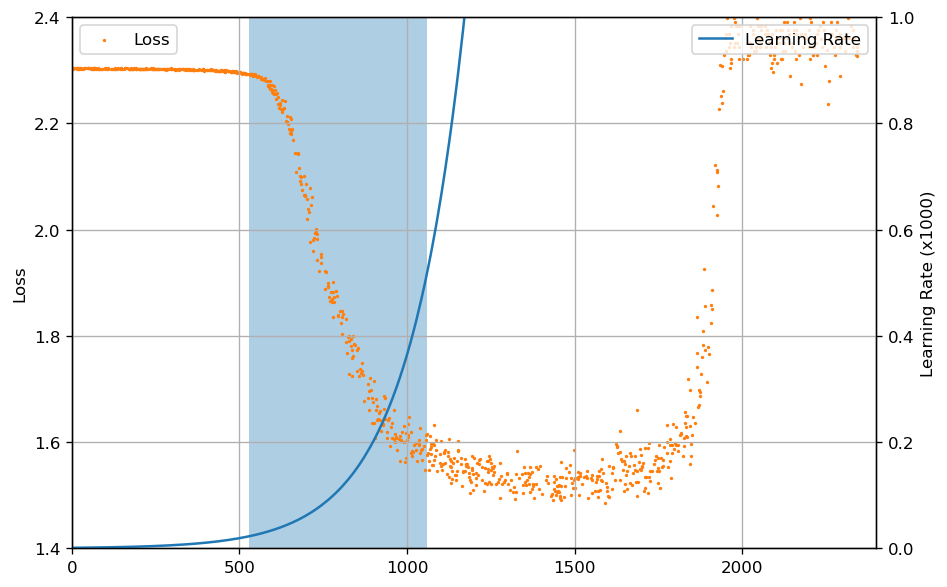

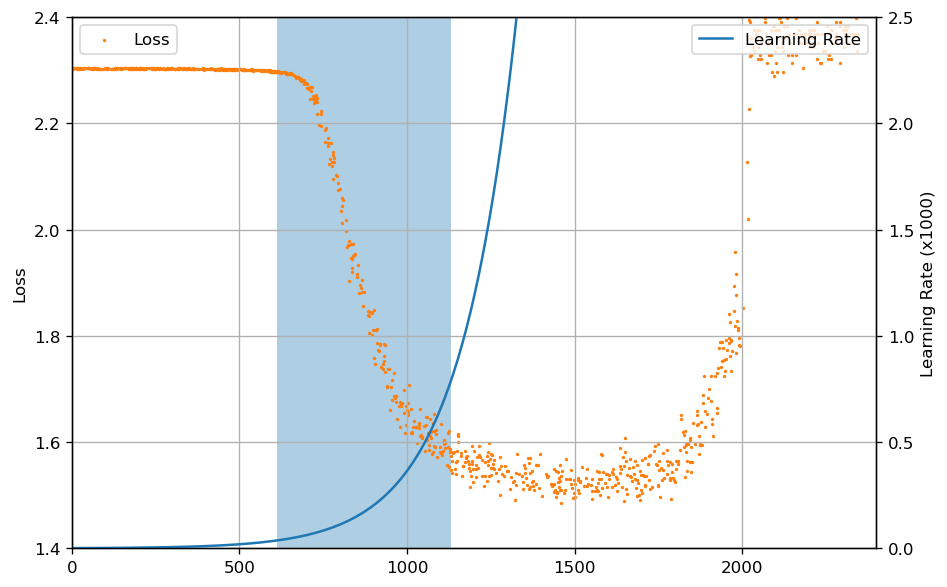

In [6]:
BASE = Path('../Report/images')

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
plot(ax, "SGD", 1)
fig.tight_layout()
fig.savefig(BASE / 'lr_range_sgd.pdf')

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
plot(ax, "Adam", 0.0010)
fig.tight_layout()
fig.savefig(BASE / 'lr_range_adam.pdf')

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
plot(ax, "AdamW", 0.0010)
fig.tight_layout()
fig.savefig(BASE / 'lr_range_adamw.pdf')

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
plot(ax, "RAdam", 0.0025)
fig.tight_layout()
fig.savefig(BASE / 'lr_range_radam.pdf')


In [7]:
for opt in ["SGD", "Adam", "AdamW", "RAdam"]:
    range = locate_lr_range(opt)
    print(r"{} & {:e} & {:e} \\".format(opt, range.min(), range.max()))


SGD & 1.349162e-02 & 1.297198e-01 \\
Adam & 2.283681e-05 & 5.154108e-04 \\
AdamW & 2.283681e-05 & 5.154108e-04 \\
RAdam & 3.723936e-05 & 7.923807e-04 \\
